
# IMPORTS

In [27]:
import pandas as pd
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from os import walk, path
import os
import sys
import numpy as np
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
import time
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
import xgboost
from sklearn.metrics import roc_auc_score
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_pipe
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from imblearn.ensemble._bagging import BalancedBaggingClassifier
from imblearn.ensemble._forest import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.pipeline import Pipeline as sk_pipe
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost
import catboost
from  imblearn.ensemble._bagging import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

# CONSTANTS

In [28]:
NUMERIC_DIR = r"C:\Users\Dana\Documents\Final_Project\Data\processed\numeric_files"
CATEGORICAL_DIR = r"C:\Users\Dana\Documents\Final_Project\Data\processed\categorial_files"
META_DIR = r"C:\Users\Dana\Documents\Final_Project\Data\processed\meta_files"
ORDINAL_DIR =  r"C:\Users\Dana\Documents\Final_Project\Data\processed\ordinal_files"
LABELS_PATH = r"C:\Users\Dana\Documents\Final_Project\Data\processed\labels.csv"

In [13]:
NUMERICAL_COLS = os.listdir(NUMERIC_DIR)
CATEGORICAL_COLS = os.listdir(CATEGORICAL_DIR)
NUMERICAL_COLS = [name.split(".")[0] for name in NUMERICAL_COLS]
ORDINAL_COLS = os.listdir(ORDINAL_DIR)
ORDINAL_COLS = [name.split(".")[0] for name in ORDINAL_COLS]
CATEGORICAL_COLS = [name.split(".")[0] for name in CATEGORICAL_COLS]
CATEGORICAL_COLS.remove('Airway')

# CREATE GROUPED DATA PER TYPE

In [50]:
numeric_df = pd.DataFrame(columns=["key", 'time', "value"])
start_time = time.time()
for root, dirs, files in walk(NUMERIC_DIR, topdown=False):
    for name in files:
        temp_path = path.join(NUMERIC_DIR,name)
        temp_raw_df = pd.read_csv(temp_path)
        temp_raw_df["time"] = pd.to_datetime(temp_raw_df["time"])
        base = temp_raw_df.loc[temp_raw_df.index[0], 'time'].minute
        temp_df = temp_raw_df.groupby(['key', pd.Grouper(freq='1T', key='time', base=base)]).mean()
        temp_df = pd.DataFrame(temp_df.to_records())
        temp_df = temp_df[["key", "time", "value"]]
        name = name.split(".")[0]
        temp_df = temp_df.rename(columns={"value": name})
        print(name)
        numeric_df = pd.merge(numeric_df, temp_df, on=['key', 'time'], how='outer')
print("--- %s seconds ---" % (time.time() - start_time))
numeric_df.to_csv(r"C:\Users\Dana\Documents\Final_Project\Data\processed\numerical_data.csv")

Albumin
ArtBPD
ArtBPM
ArtBPS
Bilirubin Total
Creatinine
ETCO2
FiO2
GlucoseABG
HCO3
HCT
Hemoglobin
HR
Na-ABG
PaCO2
Pat
PEEP
PH
PiP-Peak
Platelets
Pmax
PotassiumABG
PT-INR
RR
SaturationPulse
SuctionsPerDay
Temp
TotalMinuteVolume
Urea
VTsetting
WCC
--- 1968.1092808246613 seconds ---


In [5]:
ordinal_df = pd.DataFrame(columns=["key", 'time', "value"])
start_time = time.time()
for root, dirs, files in walk(ORDINAL_DIR, topdown=False):
    for name in files:
        temp_path = path.join(ORDINAL_DIR,name)
        temp_raw_df = pd.read_csv(temp_path)
        temp_raw_df["time"] = pd.to_datetime(temp_raw_df["time"])
        base = temp_raw_df.loc[temp_raw_df.index[0], 'time'].minute
        temp_df = temp_raw_df.groupby(['key', pd.Grouper(freq='1T', key='time', base=base)]).mean()
        temp_df = pd.DataFrame(temp_df.to_records())
        temp_df = temp_df[["key", "time", "value"]]
        name = name.split(".")[0]
        temp_df = temp_df.rename(columns={"value": name})
        print(name)
        ordinal_df = pd.merge(ordinal_df, temp_df, on=['key', 'time'], how='outer')
print("--- %s seconds ---" % (time.time() - start_time))
ordinal_df.to_csv(r"C:\Users\Dana\Documents\Final_Project\Data\processed\ordinal_data.csv")

CCPOT
GCS_SOFA
PaO2_FiO2_SOFA
RASS
--- 7.181756258010864 seconds ---


In [6]:
categorical_df = pd.DataFrame(columns=["key", 'time', "value"])
start_time = time.time()
for root, dirs, files in walk(CATEGORICAL_DIR, topdown=False):
    for name in files:
        temp_path = path.join(CATEGORICAL_DIR,name)
        temp_raw_df = pd.read_csv(temp_path)
        temp_raw_df["time"] = pd.to_datetime(temp_raw_df["time"])
        base = temp_raw_df.loc[temp_raw_df.index[0], 'time'].minute
        temp_df = temp_raw_df.groupby(['key', pd.Grouper(freq='1T', key='time', base=base)]).first()
        temp_df = pd.DataFrame(temp_df.to_records())
        name = name.split(".")[0]
        temp_df = temp_df[["key", "time", "value"]]
        temp_df = temp_df.rename(columns={"value": name})
        print(name)
        categorical_df = pd.merge(categorical_df, temp_df, on=['key', 'time'], how='outer')
print("--- %s seconds ---" % (time.time() - start_time))
categorical_df.to_csv(r"C:\Users\Dana\Documents\Final_Project\Data\processed\categorical_data.csv")

Airway
Consciousness
MucusState
MucusSuction
PaO2_FiO2_Ventilated_SOFA
RespiratoryTherapy
--- 5.903905153274536 seconds ---


In [9]:
meta_df = pd.DataFrame(columns=["key", "value"])
start_time = time.time()
for root, dirs, files in walk(META_DIR, topdown=False):
    for name in files:
        temp_path = path.join(META_DIR,name)
        temp_raw_df = pd.read_csv(temp_path)
        name = name.split(".")[0]
        temp_df = temp_raw_df[["key", "value"]]
        temp_df = temp_df.rename(columns={"value": name})
        print(name)
        meta_df = pd.merge(meta_df, temp_df, on=['key'], how='outer')
meta_df.loc[:,['AntibioticsCont', 'AntibioticsIV', 'SolumedrolUse','acmv','simv','psv']] = meta_df[['AntibioticsCont', 'AntibioticsIV', 'SolumedrolUse','acmv','simv','psv']].notnull() * 1
meta_df["Antibiotics"] = meta_df['AntibioticsCont'] + meta_df["AntibioticsIV"]
meta_df["Antibiotics"] = meta_df["Antibiotics"].astype(bool)
print("--- %s seconds ---" % (time.time() - start_time))
meta_df.to_csv(r"C:\Users\Dana\Documents\Final_Project\Data\processed\meta_data.csv")

acmv
Age
AntibioticsCont
AntibioticsIV
Gender
Height
OriginalDepartment
psv
simv
SolumedrolUse
Weight
--- 0.45310187339782715 seconds ---


# LOAD GROUPED DATA

In [14]:
numeric_df = pd.read_csv(r"C:\Users\Dana\Documents\Final_Project\Data\processed\numerical_data.csv")
categorical_df = pd.read_csv(r"C:\Users\Dana\Documents\Final_Project\Data\processed\categorical_data.csv")
meta_df = pd.read_csv(r"C:\Users\Dana\Documents\Final_Project\Data\processed\meta_data.csv")
ordinal_df = pd.read_csv(r"C:\Users\Dana\Documents\Final_Project\Data\processed\ordinal_data.csv")

C:\ProgramData\Anaconda3\envs\dandush\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
labels = pd.read_csv(LABELS_PATH)
labels = labels.set_index("key")

# SUBSET TO LABELED DATA ONLY

In [16]:
ordinal_df = ordinal_df[ordinal_df["key"].isin(labels.index.tolist())]

In [17]:
numeric_df = numeric_df[numeric_df["key"].isin(labels.index.tolist())]
numeric_df.time = pd.to_datetime(numeric_df.time)

In [18]:
categorical_df = categorical_df[categorical_df["key"].isin(labels.index.tolist())]

In [19]:
meta_df = meta_df[meta_df["key"].isin(labels.index.tolist())]
meta_df = meta_df.set_index("key")

# FEATURES CREATION FUNCTIONS

In [21]:
def calc_start_end_slope(df,col_list):
    df["time"] = pd.to_datetime(df["time"])
    base = df.loc[df.index[0], 'time'].hour
    df = df.set_index("time").resample(rule='24H',base=base).median()
    df = df[col_list]
    start_end_slope = (df.iloc[0] / df.iloc[-1]).add_prefix("start_end_slope_")
    return start_end_slope

In [22]:
def calc_simple_numerical_features(df,col_list=NUMERICAL_COLS ):
    median_series = df[col_list].median().add_prefix("median_")
    start_end_slope_series = calc_start_end_slope(df,col_list)
    min_max_series = (df[col_list].max() / df[col_list].min()).add_prefix("min_max_")
    std_series = df[col_list].std().add_prefix("std_")
    min_series = df[col_list].min().add_prefix("min_")
    max_series = df[col_list].max().add_prefix("max_")
    count_series = df[col_list].count().add_prefix("count_")
    numerical_features = pd.concat([median_series, min_max_series,std_series, min_series, max_series, count_series])
    return numerical_features

In [23]:
def calc_simple_categorical_features(df):
    cat_dummy = pd.get_dummies(df[CATEGORICAL_COLS])
    cat_dummy = pd.merge(cat_dummy, df[["key"]],left_index=True, right_index=True)
    cat_dummy_grp = cat_dummy.groupby("key").max().fillna(0)
    return cat_dummy_grp

# FEATURE ENGINEERING

In [24]:
etc_period_dict = {}

In [25]:
numeric_df.time = pd.to_datetime(numeric_df.time)
numeric_feature_list = []
for i, key in enumerate(numeric_df["key"].unique()):
    temp_patient = numeric_df[numeric_df.key == key]
    temp_patient = temp_patient.sort_values("time")
    try:
        start_date = temp_patient[~temp_patient["ETCO2"].isnull()].iloc[0]["time"]
    except IndexError:
        print(key)
        continue
    end_date = start_date + timedelta(days=5)
    etc_period_dict[key] = (start_date, end_date)
    temp_patient = temp_patient[(temp_patient["time"] > start_date) & (temp_patient["time"] < end_date)]
    features = calc_simple_numerical_features(temp_patient)
    features.name = key
    numeric_feature_list.append(features)
all_numeric_feature_list = pd.DataFrame(numeric_feature_list)
all_numeric_feature_list

C:\ProgramData\Anaconda3\envs\dandush\lib\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\ProgramData\Anaconda3\envs\dandush\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


,median_Albumin,median_ArtBPD,median_ArtBPM,median_ArtBPS,median_Bilirubin Total,median_Creatinine,median_ETCO2,median_FiO2,median_GlucoseABG,median_HCO3,...,count_PotassiumABG,count_PT-INR,count_RR,count_SaturationPulse,count_SuctionsPerDay,count_Temp,count_TotalMinuteVolume,count_Urea,count_VTsetting,count_WCC
0,2.20,46.0,70.0,145.0,0.770,2.135,38.70,36.0,117.0,20.4,...,19.0,4.0,829.0,777.0,1.0,743.0,829.0,10.0,833.0,11.0
11,2.90,50.0,70.0,129.0,0.180,3.210,39.90,43.0,115.0,21.0,...,15.0,1.0,839.0,752.0,5.0,830.0,839.0,13.0,847.0,11.0
20,2.50,60.0,81.0,128.5,0.550,0.660,33.90,45.0,133.0,29.0,...,14.0,2.0,130.0,750.0,5.0,714.0,4.0,12.0,24.0,12.0
26,2.80,56.0,74.0,119.0,0.415,1.335,34.19,35.0,142.5,24.4,...,15.0,2.0,821.0,731.0,2.0,792.0,821.0,12.0,828.0,14.0
29,3.50,42.0,67.0,123.0,0.230,0.820,38.00,40.0,147.0,35.3,...,13.0,4.0,840.0,740.0,5.0,826.0,840.0,11.0,844.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,2.15,49.0,70.0,119.0,3.300,0.980,36.00,43.0,131.5,27.8,...,23.0,4.0,38.0,699.0,0.0,797.0,18.0,13.0,37.0,15.0
7989,2.40,57.0,74.0,106.0,3.120,5.770,40.00,45.0,151.0,21.7,...,23.0,14.0,738.0,813.0,1.0,839.0,740.0,14.0,742.0,16.0
7990,2.25,56.0,73.0,111.0,3.870,1.185,31.31,40.0,149.0,27.2,...,17.0,1.0,798.0,714.0,2.0,795.0,818.0,10.0,6843.0,10.0
7996,2.10,58.0,80.0,121.0,4.390,1.070,37.00,45.0,121.5,25.9,...,18.0,4.0,802.0,785.0,4.0,800.0,637.0,9.0,1460.0,13.0


In [35]:
ordinal_df.time = pd.to_datetime(ordinal_df.time)
ordinal_feature_list = []
for i, key in enumerate(ordinal_df["key"].unique()):
    
    temp_patient = ordinal_df[ordinal_df.key == key]
    
    temp_patient = temp_patient.sort_values("time")
    temp_patient = temp_patient[(temp_patient["time"] > etc_period_dict[key][0]) & (temp_patient["time"] < etc_period_dict[key][1])]
    try:
        features = calc_simple_numerical_features(temp_patient, col_list=ORDINAL_COLS)
        features.name = key
        ordinal_feature_list.append(features)
    except IndexError:
        continue
        
all_ordinal_feature_list = pd.DataFrame(ordinal_feature_list)
all_ordinal_feature_list

C:\ProgramData\Anaconda3\envs\dandush\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


,median_CCPOT,median_GCS_SOFA,median_PaO2_FiO2_SOFA,median_RASS,min_max_CCPOT,min_max_GCS_SOFA,min_max_PaO2_FiO2_SOFA,min_max_RASS,std_CCPOT,std_GCS_SOFA,...,min_PaO2_FiO2_SOFA,min_RASS,max_CCPOT,max_GCS_SOFA,max_PaO2_FiO2_SOFA,max_RASS,count_CCPOT,count_GCS_SOFA,count_PaO2_FiO2_SOFA,count_RASS
0,2.0,4.0,1.0,-3.0,2.0,1.0,1.0,0.250000,0.500000,NaN,...,1.0,-4.0,2.0,4.0,1.0,-1.0,4.0,1.0,1.0,5.0
11,3.0,4.0,1.0,-3.0,inf,1.0,1.0,-0.250000,1.925001,0.0,...,1.0,-4.0,5.0,4.0,1.0,1.0,22.0,2.0,2.0,25.0
20,0.0,4.0,1.0,0.0,NaN,1.0,1.0,-0.000000,0.000000,0.0,...,1.0,-3.0,0.0,4.0,1.0,0.0,4.0,2.0,2.0,28.0
26,0.0,4.0,1.0,-4.0,inf,1.0,1.0,0.750000,1.032796,0.0,...,1.0,-4.0,2.0,4.0,1.0,-3.0,6.0,4.0,4.0,6.0
29,1.0,4.0,1.0,-3.0,inf,1.0,1.0,0.500000,1.380004,0.0,...,1.0,-4.0,5.0,4.0,1.0,-2.0,17.0,2.0,2.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,NaN,4.0,1.0,-1.0,NaN,1.0,1.0,-0.333333,NaN,NaN,...,1.0,-3.0,NaN,4.0,1.0,1.0,0.0,1.0,1.0,22.0
3124,NaN,4.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,0.0,...,1.0,NaN,NaN,4.0,1.0,NaN,0.0,3.0,3.0,0.0
3167,NaN,4.0,1.0,-2.0,NaN,1.0,1.0,-0.666667,NaN,0.0,...,1.0,-3.0,NaN,4.0,1.0,2.0,0.0,5.0,5.0,5.0
4034,NaN,1.0,1.0,-4.0,NaN,1.0,1.0,0.750000,NaN,0.0,...,1.0,-4.0,NaN,1.0,1.0,-3.0,0.0,3.0,3.0,14.0


In [38]:
categorical_df.time = pd.to_datetime(categorical_df.time)
categorical_feature_list = []
for i, key in enumerate(categorical_df["key"].unique()):
    temp_patient = categorical_df[categorical_df.key == key]
    temp_patient = temp_patient.sort_values("time")
    temp_patient = temp_patient[(temp_patient["time"] > etc_period_dict[key][0]) & (temp_patient["time"] < etc_period_dict[key][1])]
    features = calc_simple_categorical_features(temp_patient)
    features.name = key
    categorical_feature_list.append(features)
all_categorical_features= pd.concat(categorical_feature_list, axis=0)
all_categorical_features

C:\ProgramData\Anaconda3\envs\dandush\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,Consciousness_coma,Consciousness_confused,Consciousness_conscious,Consciousness_delirium,Consciousness_fluctuated,Consciousness_obtunded,Consciousness_stupor,Consciousness_unconscious,Consciousness_under_anesthesia,MucusState_ambu_saline,...,PaO2_FiO2_Ventilated_SOFA_ventilated,RespiratoryTherapy_cough_encouragement,RespiratoryTherapy_couging,RespiratoryTherapy_expirium1-triflow,RespiratoryTherapy_expirium2-triflow,RespiratoryTherapy_inspirium1-triflow,RespiratoryTherapy_inspirium2-triflow,RespiratoryTherapy_other,RespiratoryTherapy_respiratory_exercise,RespiratoryTherapy_suction
key,,,,,,,,,,,,,,,,,,,,,
0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
11,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
26,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
29,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7990,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [39]:
final_df = pd.merge(all_numeric_feature_list, all_categorical_features,left_index=True, right_index=True, how="left")
final_df = pd.merge(final_df, meta_df,left_index=True, right_index=True, how="left")
final_df = pd.merge(final_df, all_ordinal_feature_list,left_index=True, right_index=True, how="left")
final_df = final_df.replace({"Gender":{"female":True, "male":False}})
dummies_df = pd.get_dummies(final_df[["OriginalDepartment"]])
final_df = pd.merge(final_df, dummies_df,left_index=True, right_index=True, how="left")
final_df = final_df.drop(columns="OriginalDepartment")

In [40]:
final_df["labels"] = labels["label_clf"]
final_df = final_df.replace([np.inf, -np.inf], np.nan)
final_df = final_df.fillna(-7000)
x = final_df.drop(columns="labels")
y = final_df.labels

In [70]:
y

0       yes
11      yes
20      yes
26      yes
29      yes
       ... 
7982     no
7989    yes
7990    yes
7996    yes
8000    yes
Name: labels, Length: 729, dtype: object

# MODELS

In [41]:
models = [
    {'name': 'decision',
     'classifier':imb_pipe([('smot',SMOTE(random_state=42)),('pca',PCA()),('clf',DecisionTreeClassifier())]),
     'grid': dict(pca__n_components=[15,20], 
                  clf__max_depth=[10,20,30,40,50,60,70,80,90,100,None], 
                  clf__max_features=['auto','sqrt'],clf__min_samples_leaf=[1,2,4], 
                  clf__min_samples_split=[2,5,10])},
    {'name': 'rf',
     'classifier':imb_pipe([('smot',SMOTE(random_state=42)),('pca',PCA()),('clf',RandomForestClassifier())]),
     'grid': dict(pca__n_components=[15,20], clf__bootstrap=[True,False], 
                  clf__max_depth=[10,20,30,40,50,60,70,80,90,100,None], 
                  clf__max_features=['auto','sqrt'],clf__min_samples_leaf=[1,2,4], 
                  clf__min_samples_split=[2,5,10],clf__n_estimators=[200,400,600])},
    {'name': 'brf',
     'classifier':imb_pipe([('pca',PCA()),('clf', BalancedRandomForestClassifier())]),
     'grid': dict(pca__n_components=[15,20],clf__bootstrap=[True,False], 
                  clf__max_depth=[10,20,30,40,50,60,70,80,90,100,None], 
                  clf__max_features=['auto','sqrt'],clf__min_samples_leaf=[1,2,4], 
                  clf__min_samples_split=[2,5,10],clf__n_estimators=[200,400,600])},
    {'name': 'xgboost', 
     'classifier': imb_pipe([('pca',PCA()),('clf',xgboost.XGBClassifier(n_estimators=500,n_jobs=-1,scale_pos_weight=3))]),
     'grid': dict(pca__n_components=[15,20],clf__scale_pos_weight=[0.3,0.5,1],clf__min_child_weight=[1,5,10],
                  clf__gamma=[0.5,1,1.5,2,5],clf__subsample=[0.6,0.8,1.0],clf__colsample_bytree=[0.6,0.8,1.0],
                  clf__max_depth=[3,4,5])},
    {'name': 'catboost',
   'classifier': imb_pipe([('pca',PCA()),('clf',catboost.CatBoostClassifier(thread_count=4, verbose=0))]),
  'grid': dict(pca__n_components=[15,20],clf__scale_pos_weight=[0.3], 
              clf__depth=[7],clf__iterations=[250,500],clf__learning_rate=[0.01],clf__l2_leaf_reg=[5,10])},
    {'name': 'adaboost',
     'classifier': imb_pipe([('smot',SMOTE(random_state=42)),('pca',PCA()),('clf',AdaBoostClassifier())]),
     'grid': dict(pca__n_components=[15,20], clf__n_estimators=[250,500,1000], clf__learning_rate=[0.01, 0.1, 0.5, 1],
                 clf__algorithm=['SAMME', 'SAMME.R'])}
    
]

# MODEL SELECTION

In [42]:
def model_selection(classifier, name, grid, X_train, y_train, scoring):
    N_ITER = 50
    CV = 10
    gridsearch_cv=RandomizedSearchCV(classifier, 
                               grid,
                               cv=CV, n_iter=N_ITER,
                               scoring = scoring, refit='AUC', random_state=42)
    gridsearch_cv.fit(X_train, y_train)
    
    results_dict = {}
    
    results_dict['classifier_name'] = name    
    results_dict['classifier'] = gridsearch_cv.best_estimator_
    results_dict['best_params'] = gridsearch_cv.best_params_
    results_dict['score'] = gridsearch_cv.best_score_
    results_dict['results'] = gridsearch_cv.cv_results_ 
    return(results_dict)


results = []
for m in models:    
    print(m['name'])
    y_bool = y.replace({"yes":1.0, "no":0.0})
    results.append(model_selection(m['classifier'], 
                                   m['name'],
                                   m['grid'],
                                   x, y_bool, {'AUC': 'roc_auc', 'f1': 'f1_weighted', 'precision':'precision_weighted', 
                                               'recall': 'recall_weighted', 'accuracy':'accuracy'}))      
    print('completed')

catboost


C:\ProgramData\Anaconda3\envs\dandush\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\ProgramData\Anaconda3\envs\dandush\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


completed


In [45]:
for res in results:
    print("{} : {}".format(res["classifier_name"], res["score"]))

decision : 0.6119608606744608
rf : 0.6685546573568417
brf : 0.6626519055934273
xgboost : 0.6573111145317634
catboost : 0.6748500223073954
adaboost : 0.6708767593466675


## PARAMETERS SELECTION BY 'mean_test_AUC'

### DT

In [95]:
decision_auc_scores = pd.DataFrame(results[0]["results"])[["mean_test_AUC"]]
dt_idmax = decision_auc_scores.loc[decision_auc_scores['mean_test_AUC'].idxmax()]
dt_idmin = decision_auc_scores.loc[decision_auc_scores['mean_test_AUC'].idxmin()]
print(dt_idmax,'\n',dt_idmin)

mean_test_AUC    0.611961
Name: 4, dtype: float64 
 mean_test_AUC    0.506204
Name: 37, dtype: float64


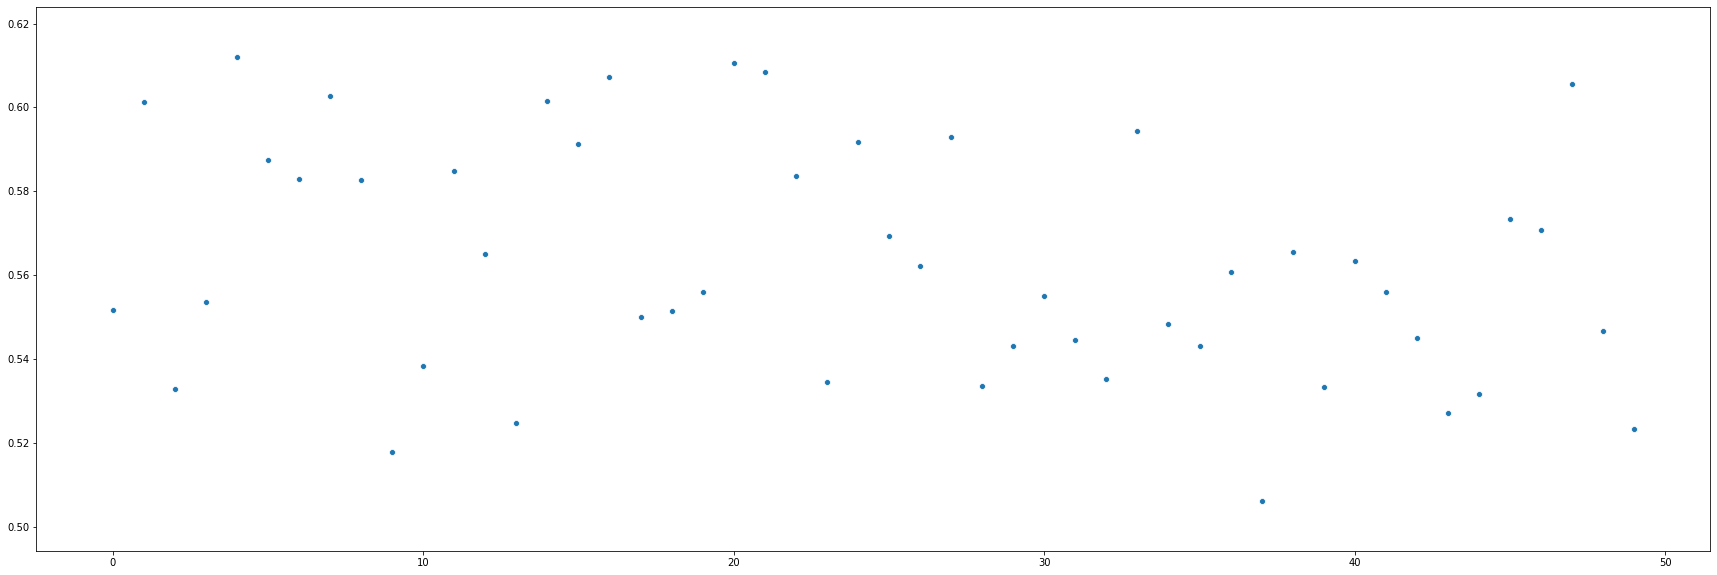

In [80]:
plt.figure(figsize=(30,10))
sns.scatterplot(x=decision_auc_scores.index, y=decision_auc_scores['mean_test_AUC'].values)

In [81]:
 pd.DataFrame(results[0]["results"]).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_pca__n_components', 'param_clf__min_samples_split',
       'param_clf__min_samples_leaf', 'param_clf__max_features',
       'param_clf__max_depth', 'params', 'split0_test_AUC', 'split1_test_AUC',
       'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC',
       'split5_test_AUC', 'split6_test_AUC', 'split7_test_AUC',
       'split8_test_AUC', 'split9_test_AUC', 'mean_test_AUC', 'std_test_AUC',
       'rank_test_AUC', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1',
       'split3_test_f1', 'split4_test_f1', 'split5_test_f1', 'split6_test_f1',
       'split7_test_f1', 'split8_test_f1', 'split9_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision',
       'split5_test_precision', 'split6_test_precision',
       'split7_test_precision', 'split8

In [100]:
 pd.DataFrame(results[0]["results"]).loc[[dt_idmax.name,dt_idmin.name],['param_pca__n_components', 'param_clf__min_samples_split',
                                                   'param_clf__min_samples_leaf','param_clf__max_features',
                                                   'param_clf__max_depth','mean_test_AUC']]

,param_pca__n_components,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__max_depth,mean_test_AUC
4,20,2,4,sqrt,None,0.611961
37,20,5,1,sqrt,20,0.506204


###  RF

In [101]:
rf_auc_scores = pd.DataFrame(results[1]["results"])[["mean_test_AUC"]]
rf_idmax = rf_auc_scores.loc[rf_auc_scores['mean_test_AUC'].idxmax()]
rf_idmin = rf_auc_scores.loc[rf_auc_scores['mean_test_AUC'].idxmin()]
print(rf_idmax,'\n',rf_idmin)

mean_test_AUC    0.668555
Name: 23, dtype: float64 
 mean_test_AUC    0.624801
Name: 8, dtype: float64


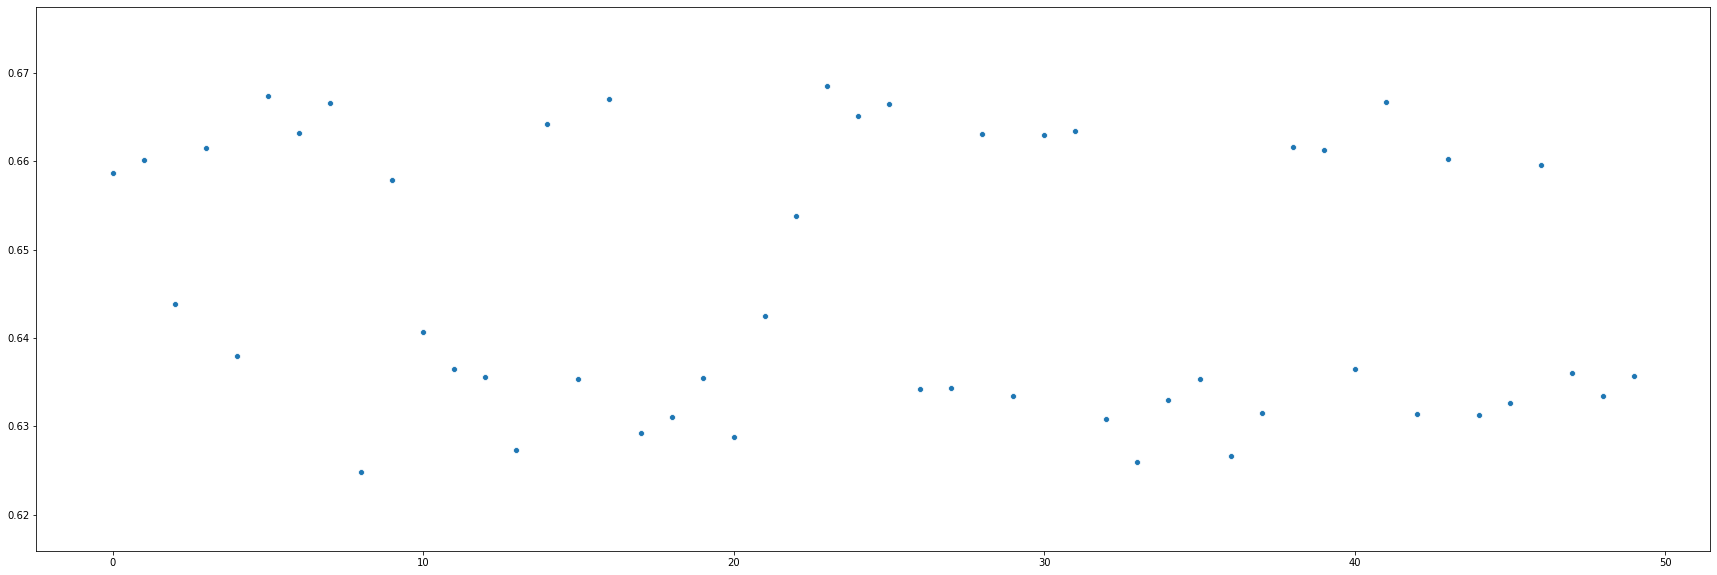

In [102]:
plt.figure(figsize=(30,10))
sns.scatterplot(x=rf_auc_scores.index, y=rf_auc_scores['mean_test_AUC'].values)

In [85]:
 pd.DataFrame(results[1]["results"]).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_pca__n_components', 'param_clf__n_estimators',
       'param_clf__min_samples_split', 'param_clf__min_samples_leaf',
       'param_clf__max_features', 'param_clf__max_depth',
       'param_clf__bootstrap', 'params', 'split0_test_AUC', 'split1_test_AUC',
       'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC',
       'split5_test_AUC', 'split6_test_AUC', 'split7_test_AUC',
       'split8_test_AUC', 'split9_test_AUC', 'mean_test_AUC', 'std_test_AUC',
       'rank_test_AUC', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1',
       'split3_test_f1', 'split4_test_f1', 'split5_test_f1', 'split6_test_f1',
       'split7_test_f1', 'split8_test_f1', 'split9_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision',
       'split5_test_precision', 'split

In [103]:
 pd.DataFrame(results[1]["results"]).loc[[rf_idmax.name,rf_idmin.name],['param_pca__n_components', 'param_clf__n_estimators',
       'param_clf__min_samples_split', 'param_clf__min_samples_leaf',
       'param_clf__max_features', 'param_clf__max_depth','param_clf__bootstrap','mean_test_AUC']]

,param_pca__n_components,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__max_depth,param_clf__bootstrap,mean_test_AUC
23,20,600,2,4,sqrt,10,False,0.668555
8,15,400,10,2,sqrt,100,True,0.624801


### BRF 

In [104]:
brf_auc_scores = pd.DataFrame(results[2]["results"])[["mean_test_AUC"]]
brf_idmax = brf_auc_scores.loc[brf_auc_scores['mean_test_AUC'].idxmax()]
brf_idmin = brf_auc_scores.loc[brf_auc_scores['mean_test_AUC'].idxmin()]
print(brf_idmax,'\n',brf_idmin)

mean_test_AUC    0.662652
Name: 28, dtype: float64 
 mean_test_AUC    0.581803
Name: 48, dtype: float64


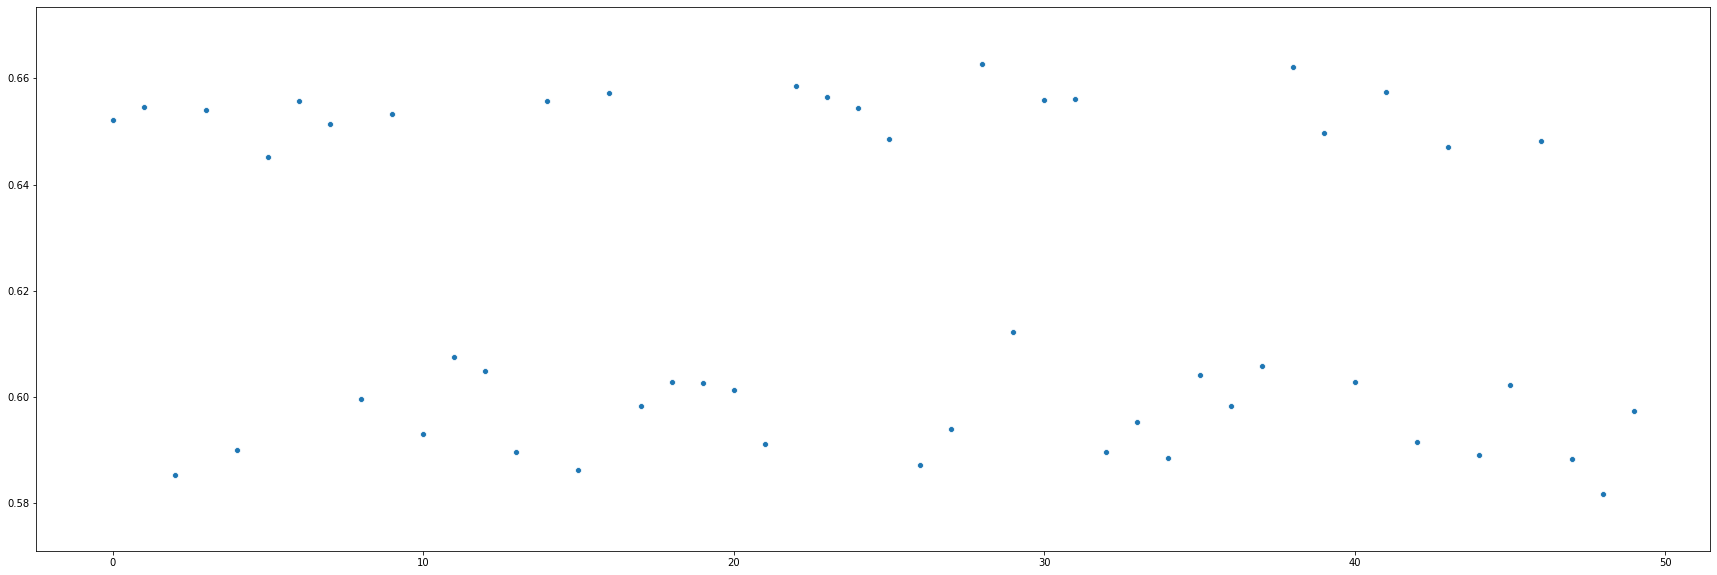

In [105]:
plt.figure(figsize=(30,10))
sns.scatterplot(x=brf_auc_scores.index, y=brf_auc_scores['mean_test_AUC'].values)

In [106]:
 pd.DataFrame(results[2]["results"]).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_pca__n_components', 'param_clf__n_estimators',
       'param_clf__min_samples_split', 'param_clf__min_samples_leaf',
       'param_clf__max_features', 'param_clf__max_depth',
       'param_clf__bootstrap', 'params', 'split0_test_AUC', 'split1_test_AUC',
       'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC',
       'split5_test_AUC', 'split6_test_AUC', 'split7_test_AUC',
       'split8_test_AUC', 'split9_test_AUC', 'mean_test_AUC', 'std_test_AUC',
       'rank_test_AUC', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1',
       'split3_test_f1', 'split4_test_f1', 'split5_test_f1', 'split6_test_f1',
       'split7_test_f1', 'split8_test_f1', 'split9_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision',
       'split5_test_precision', 'split

In [107]:
 pd.DataFrame(results[2]["results"]).loc[[brf_idmax.name,brf_idmin.name],['param_pca__n_components', 'param_clf__n_estimators',
       'param_clf__min_samples_split', 'param_clf__min_samples_leaf',
       'param_clf__max_features', 'param_clf__max_depth','param_clf__bootstrap','mean_test_AUC']]

,param_pca__n_components,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__max_depth,param_clf__bootstrap,mean_test_AUC
28,20,400,2,2,auto,30,True,0.662652
48,15,200,5,2,sqrt,60,True,0.581803


### XGboost 

In [108]:
xgboost_auc_scores = pd.DataFrame(results[3]["results"])[["mean_test_AUC"]]
xgboost_idmax = xgboost_auc_scores.loc[xgboost_auc_scores['mean_test_AUC'].idxmax()]
xgboost_idmin = xgboost_auc_scores.loc[xgboost_auc_scores['mean_test_AUC'].idxmin()]
print(xgboost_idmax,'\n',xgboost_idmin)

mean_test_AUC    0.657311
Name: 34, dtype: float64 
 mean_test_AUC    0.573022
Name: 21, dtype: float64


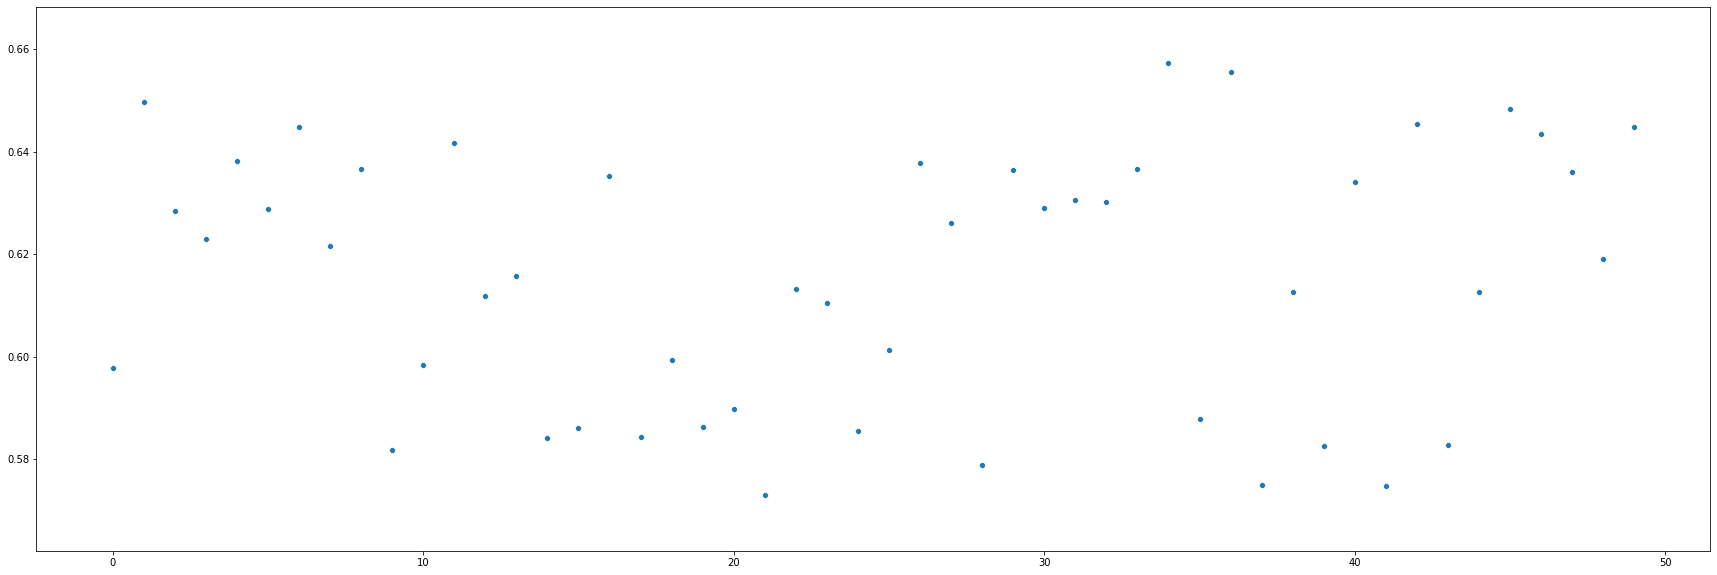

In [109]:
plt.figure(figsize=(30,10))
sns.scatterplot(x=xgboost_auc_scores.index, y=xgboost_auc_scores['mean_test_AUC'].values)

In [110]:
 pd.DataFrame(results[3]["results"]).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_pca__n_components', 'param_clf__subsample',
       'param_clf__scale_pos_weight', 'param_clf__min_child_weight',
       'param_clf__max_depth', 'param_clf__gamma',
       'param_clf__colsample_bytree', 'params', 'split0_test_AUC',
       'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC',
       'split4_test_AUC', 'split5_test_AUC', 'split6_test_AUC',
       'split7_test_AUC', 'split8_test_AUC', 'split9_test_AUC',
       'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_test_f1',
       'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1',
       'split5_test_f1', 'split6_test_f1', 'split7_test_f1', 'split8_test_f1',
       'split9_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1',
       'split0_test_precision', 'split1_test_precision',
       'split2_test_precision', 'split3_test_precision',
       'split4_test_precision', 'split5_test_precision',
       'sp

In [112]:
 pd.DataFrame(results[3]["results"]).loc[[xgboost_idmax.name,xgboost_idmin.name],[ 'param_pca__n_components', 'param_clf__subsample',
       'param_clf__scale_pos_weight', 'param_clf__min_child_weight',
       'param_clf__max_depth','mean_test_AUC']]

,param_pca__n_components,param_clf__subsample,param_clf__scale_pos_weight,param_clf__min_child_weight,param_clf__max_depth,mean_test_AUC
34,20,0.8,0.3,10,5,0.657311
21,15,0.6,0.3,10,4,0.573022


### CATboost 

In [113]:
catboost_auc_scores = pd.DataFrame(results[4]["results"])[["mean_test_AUC"]]
catboost_idmax = catboost_auc_scores.loc[catboost_auc_scores['mean_test_AUC'].idxmax()]
catboost_idmin = catboost_auc_scores.loc[catboost_auc_scores['mean_test_AUC'].idxmin()]
print(catboost_idmax,'\n',catboost_idmin)

mean_test_AUC    0.67485
Name: 1, dtype: float64 
 mean_test_AUC    0.609379
Name: 2, dtype: float64


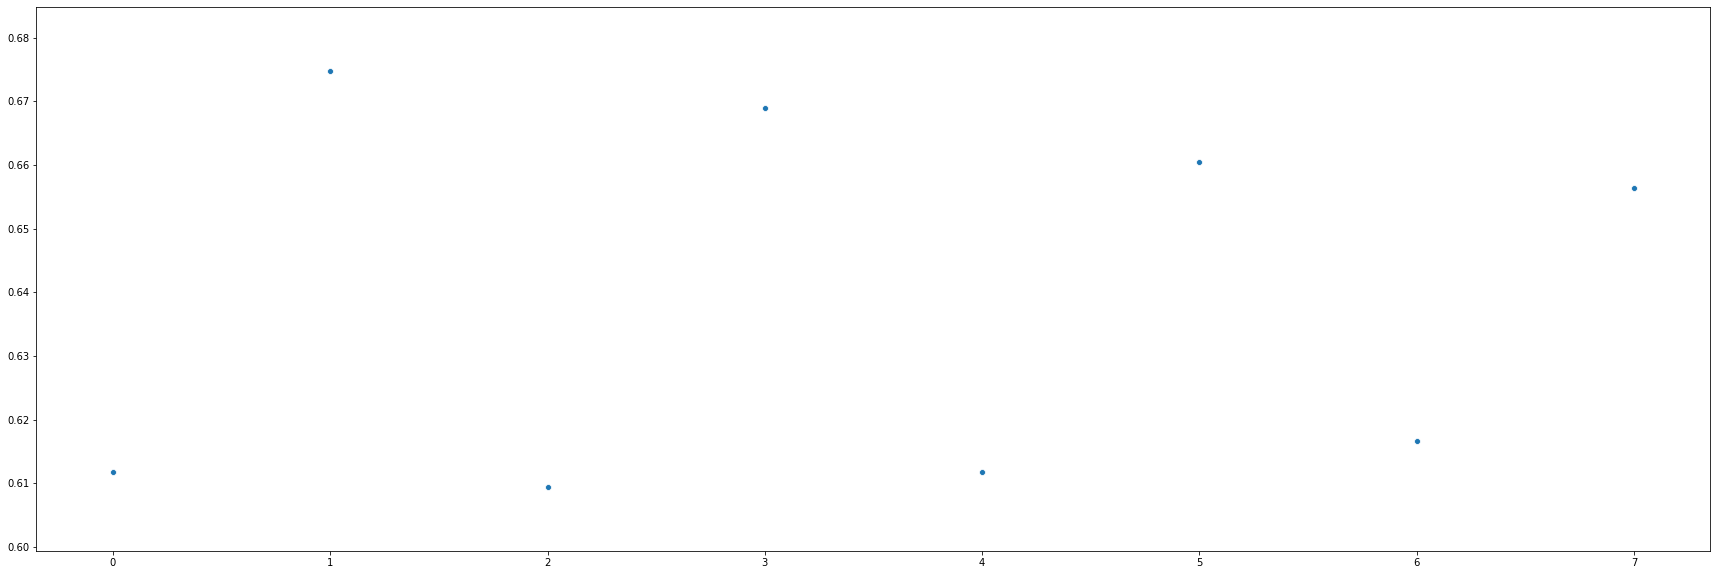

In [114]:
plt.figure(figsize=(30,10))
sns.scatterplot(x=catboost_auc_scores.index, y=catboost_auc_scores['mean_test_AUC'].values)

In [115]:
 pd.DataFrame(results[4]["results"]).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_pca__n_components', 'param_clf__scale_pos_weight',
       'param_clf__learning_rate', 'param_clf__l2_leaf_reg',
       'param_clf__iterations', 'param_clf__depth', 'params',
       'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC',
       'split3_test_AUC', 'split4_test_AUC', 'split5_test_AUC',
       'split6_test_AUC', 'split7_test_AUC', 'split8_test_AUC',
       'split9_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
       'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1',
       'split4_test_f1', 'split5_test_f1', 'split6_test_f1', 'split7_test_f1',
       'split8_test_f1', 'split9_test_f1', 'mean_test_f1', 'std_test_f1',
       'rank_test_f1', 'split0_test_precision', 'split1_test_precision',
       'split2_test_precision', 'split3_test_precision',
       'split4_test_precision', 'split5_test_precision',
       'split6_test_precision', 'split7_test_pre

In [116]:
 pd.DataFrame(results[4]["results"]).loc[[catboost_idmax.name,catboost_idmin.name],['param_pca__n_components', 'param_clf__scale_pos_weight',
       'param_clf__learning_rate', 'param_clf__l2_leaf_reg',
       'param_clf__iterations', 'param_clf__depth','mean_test_AUC']]

,param_pca__n_components,param_clf__scale_pos_weight,param_clf__learning_rate,param_clf__l2_leaf_reg,param_clf__iterations,param_clf__depth,mean_test_AUC
1,20,0.3,0.01,5,250,7,0.674850
2,15,0.3,0.01,10,250,7,0.609379


### ADAboost 

In [117]:
adaboost_auc_scores = pd.DataFrame(results[5]["results"])[["mean_test_AUC"]]
adatboost_idmax = adaboost_auc_scores.loc[adaboost_auc_scores['mean_test_AUC'].idxmax()]
adatboost_idmin = adaboost_auc_scores.loc[adaboost_auc_scores['mean_test_AUC'].idxmin()]
print(adatboost_idmax,'\n',adatboost_idmin)

mean_test_AUC    0.670877
Name: 15, dtype: float64 
 mean_test_AUC    0.561
Name: 46, dtype: float64


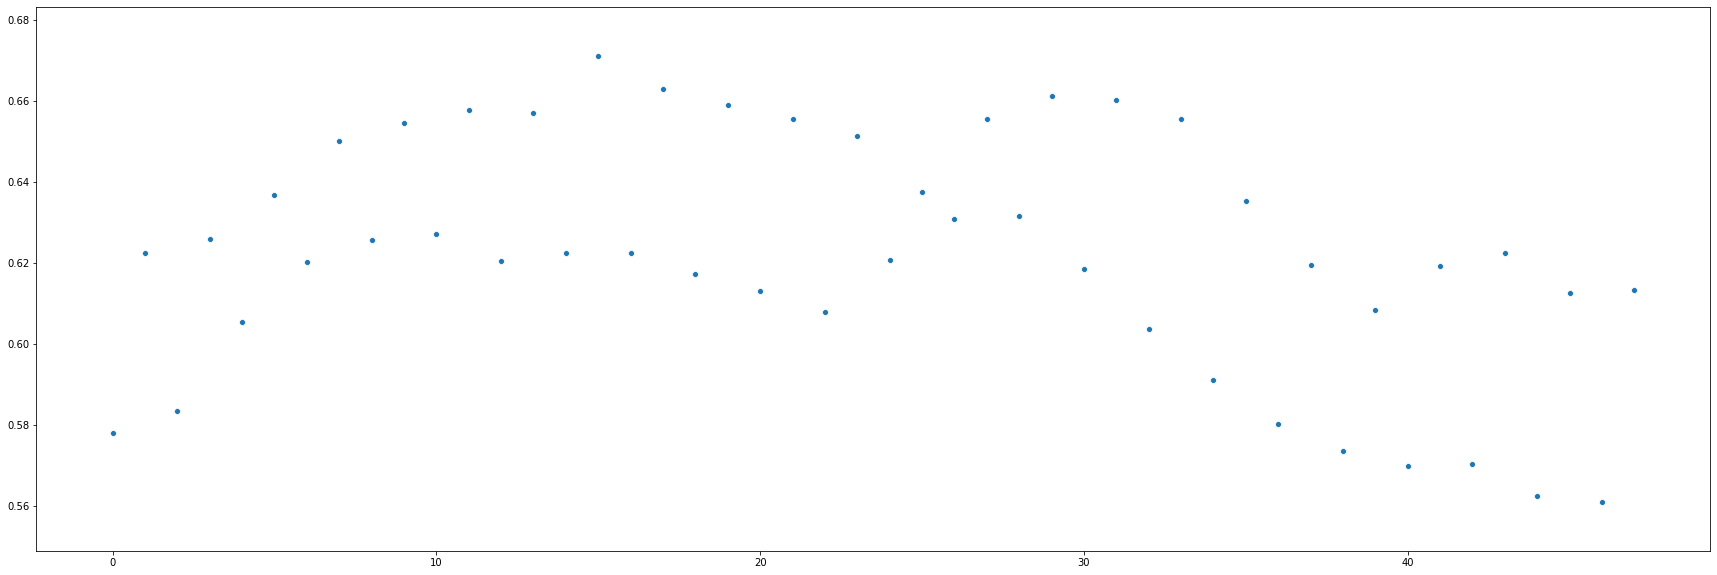

In [118]:
plt.figure(figsize=(30,10))
sns.scatterplot(x=adaboost_auc_scores.index, y=adaboost_auc_scores['mean_test_AUC'].values)

In [119]:
 pd.DataFrame(results[5]["results"]).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_pca__n_components', 'param_clf__n_estimators',
       'param_clf__learning_rate', 'param_clf__algorithm', 'params',
       'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC',
       'split3_test_AUC', 'split4_test_AUC', 'split5_test_AUC',
       'split6_test_AUC', 'split7_test_AUC', 'split8_test_AUC',
       'split9_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
       'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1',
       'split4_test_f1', 'split5_test_f1', 'split6_test_f1', 'split7_test_f1',
       'split8_test_f1', 'split9_test_f1', 'mean_test_f1', 'std_test_f1',
       'rank_test_f1', 'split0_test_precision', 'split1_test_precision',
       'split2_test_precision', 'split3_test_precision',
       'split4_test_precision', 'split5_test_precision',
       'split6_test_precision', 'split7_test_precision',
       'split8_test_precision', 'split9_test_prec

In [120]:
 pd.DataFrame(results[5]["results"]).loc[[adatboost_idmax.name,adatboost_idmin.name],[ 'param_pca__n_components', 'param_clf__n_estimators',
       'param_clf__learning_rate', 'param_clf__algorithm','mean_test_AUC']]

,param_pca__n_components,param_clf__n_estimators,param_clf__learning_rate,param_clf__algorithm,mean_test_AUC
15,20,500,0.5,SAMME,0.670877
46,15,1000,1,SAMME.R,0.561000


# RUNNING MODELS WITH SELECTED PARAMETERS

In [46]:
def run_kfold(model,model_name,x,y):
    print(model_name)
    best_clf = model
    precision_list = []
    recall_list = []
    f1_list = []
    auc_list = []
    accuaracy_list = []
    KFold(n_splits=10,random_state=42,shuffle=False)
    kf = KFold(n_splits=10)
    i = 0
    for train_index, test_index in kf.split(x):
        X_train_fold, X_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        best_clf.fit(X_train_fold, y_train_fold)
        pred = best_clf.predict(X_test_fold)
        pred_prob = best_clf.predict_proba(X_test_fold)
        print("fold {}".format(i))
        i += 1
        print(classification_report(y_test_fold, pred))
        precision_list.append(precision_score(y_test_fold, pred,average="weighted"))
        recall_list.append(recall_score(y_test_fold, pred,average="weighted"))
        f1_list.append(f1_score(y_test_fold, pred ,average="weighted"))
        accuaracy_list.append(accuracy_score(y_test_fold, pred))
        pred_zip = [item[1] for item in pred_prob]
        auc_list.append(roc_auc_score(y_test_fold, pred_zip, average="weighted"))
    return precision_list,recall_list,f1_list,accuaracy_list,auc_list
    

In [47]:
precision_list_decision,recall_list_decision,f1_list_decision,accuaracy_list_decision,auc_list_decision =  run_kfold(results[0]['classifier'],results[0]['classifier_name'], x, y_bool)

decision
fold 0
              precision    recall  f1-score   support

         0.0       0.33      0.50      0.40        18
         1.0       0.80      0.67      0.73        55

    accuracy                           0.63        73
   macro avg       0.57      0.59      0.57        73
weighted avg       0.69      0.63      0.65        73

fold 1
              precision    recall  f1-score   support

         0.0       0.38      0.50      0.43        26
         1.0       0.67      0.55      0.60        47

    accuracy                           0.53        73
   macro avg       0.52      0.53      0.52        73
weighted avg       0.57      0.53      0.54        73

fold 2
              precision    recall  f1-score   support

         0.0       0.25      0.32      0.28        19
         1.0       0.73      0.67      0.70        54

    accuracy                           0.58        73
   macro avg       0.49      0.49      0.49        73
weighted avg       0.61      0.58      0.59 

In [122]:
print(precision_list_decision,'\n',recall_list_decision,'\n',f1_list_decision,'\n',accuaracy_list_decision,'\n',auc_list_decision)

[0.6882072662298988, 0.5654042438893365, 0.6085406765445904, 0.6676661826904866, 0.6176724669875355, 0.6080559415878058, 0.6979276431331226, 0.6975363703939684, 0.7401618929016189, 0.6432326472422704] 
 [0.6301369863013698, 0.5342465753424658, 0.5753424657534246, 0.6027397260273972, 0.5616438356164384, 0.589041095890411, 0.5753424657534246, 0.6301369863013698, 0.547945205479452, 0.5555555555555556] 
 [0.6506442425064424, 0.5436338536688966, 0.5897246355743745, 0.6225822412598782, 0.5748964638419879, 0.5969178082191782, 0.6081230473443883, 0.6506806083540605, 0.6064288620642887, 0.5863156856945676] 
 [0.6301369863013698, 0.5342465753424658, 0.5753424657534246, 0.6027397260273972, 0.5616438356164384, 0.589041095890411, 0.5753424657534246, 0.6301369863013698, 0.547945205479452, 0.5555555555555556] 
 [0.6131313131313132, 0.5380523731587561, 0.4605263157894737, 0.6099056603773585, 0.5680272108843537, 0.5556521739130434, 0.6081932773109244, 0.601364522417154, 0.592896174863388, 0.55775401069

In [48]:
precision_list_rf,recall_list_rf,f1_list_rf,accuaracy_list_rf,auc_list_rf =  run_kfold(results[1]['classifier'],results[1]['classifier_name'], x, y_bool)

rf
fold 0
              precision    recall  f1-score   support

         0.0       0.38      0.33      0.35        18
         1.0       0.79      0.82      0.80        55

    accuracy                           0.70        73
   macro avg       0.58      0.58      0.58        73
weighted avg       0.69      0.70      0.69        73

fold 1
              precision    recall  f1-score   support

         0.0       0.45      0.50      0.47        26
         1.0       0.70      0.66      0.68        47

    accuracy                           0.60        73
   macro avg       0.58      0.58      0.58        73
weighted avg       0.61      0.60      0.61        73

fold 2
              precision    recall  f1-score   support

         0.0       0.56      0.26      0.36        19
         1.0       0.78      0.93      0.85        54

    accuracy                           0.75        73
   macro avg       0.67      0.59      0.60        73
weighted avg       0.72      0.75      0.72       

In [123]:
print(precision_list_rf,'\n',recall_list_rf,'\n',f1_list_rf,'\n',accuaracy_list_rf,'\n',auc_list_rf)

[0.6872746935832732, 0.6132713531154722, 0.7225076103500762, 0.707909423482603, 0.6874127681571466, 0.7151325803092207, 0.7747503637914598, 0.5958212259582123, 0.7895606991025035, 0.7526175213675214] 
 [0.6986301369863014, 0.6027397260273972, 0.7534246575342466, 0.7123287671232876, 0.6986301369863014, 0.726027397260274, 0.7534246575342466, 0.6027397260273972, 0.7671232876712328, 0.7361111111111112] 
 [0.6924571198342351, 0.6070258508614673, 0.7198414541112474, 0.709984932491654, 0.6908407198495837, 0.7182497867429375, 0.7618360970920453, 0.5991936387814232, 0.777125462056969, 0.7431099323622689] 
 [0.6986301369863014, 0.6027397260273972, 0.7534246575342466, 0.7123287671232876, 0.6986301369863014, 0.726027397260274, 0.7534246575342466, 0.6027397260273972, 0.7671232876712328, 0.7361111111111112] 
 [0.6272727272727273, 0.574468085106383, 0.5584795321637428, 0.659433962264151, 0.6683673469387754, 0.6852173913043478, 0.7741596638655462, 0.5097465886939572, 0.6489071038251366, 0.711229946524

In [49]:
precision_list_brf,recall_list_brf,f1_list_brf,accuaracy_list_brf,auc_list_brf =  run_kfold(results[2]['classifier'],results[2]['classifier_name'], x, y_bool)

brf
fold 0
              precision    recall  f1-score   support

         0.0       0.32      0.67      0.43        18
         1.0       0.83      0.53      0.64        55

    accuracy                           0.56        73
   macro avg       0.57      0.60      0.54        73
weighted avg       0.70      0.56      0.59        73

fold 1
              precision    recall  f1-score   support

         0.0       0.44      0.65      0.52        26
         1.0       0.74      0.53      0.62        47

    accuracy                           0.58        73
   macro avg       0.59      0.59      0.57        73
weighted avg       0.63      0.58      0.58        73

fold 2
              precision    recall  f1-score   support

         0.0       0.39      0.63      0.48        19
         1.0       0.83      0.65      0.73        54

    accuracy                           0.64        73
   macro avg       0.61      0.64      0.60        73
weighted avg       0.72      0.64      0.66      

In [125]:
print(precision_list_brf,recall_list_brf,f1_list_brf,accuaracy_list_brf,auc_list_brf)

[0.7021320424348543, 0.6286596830513028, 0.717189571365444, 0.6920137918180972, 0.6951258362535839, 0.6621747902729107, 0.7821502698215027, 0.6781680766092669, 0.7919053549190535, 0.7142213642213642] [0.5616438356164384, 0.5753424657534246, 0.6438356164383562, 0.6712328767123288, 0.6712328767123288, 0.6301369863013698, 0.6712328767123288, 0.6164383561643836, 0.6027397260273972, 0.5833333333333334] [0.5912154816264406, 0.5837307627261966, 0.6643150684931507, 0.6797304226796572, 0.6787770498312488, 0.640642326515979, 0.6964383561643835, 0.6368232224396607, 0.6541344545413444, 0.6146878483835005] [0.5616438356164384, 0.5753424657534246, 0.6438356164383562, 0.6712328767123288, 0.6712328767123288, 0.6301369863013698, 0.6712328767123288, 0.6164383561643836, 0.6027397260273972, 0.5833333333333334] [0.6282828282828282, 0.5613747954173487, 0.7085769980506823, 0.6754716981132075, 0.71343537414966, 0.6608695652173913, 0.8130252100840336, 0.5516569200779727, 0.6311475409836066, 0.7016042780748664]

In [50]:
precision_list_xgboost,recall_list_xgboost,f1_list_xgboost,accuaracy_list_xgboost,auc_list_xgboost =  run_kfold(results[3]['classifier'],results[3]['classifier_name'], x, y_bool)

xgboost
fold 0
              precision    recall  f1-score   support

         0.0       0.27      0.67      0.38        18
         1.0       0.79      0.40      0.53        55

    accuracy                           0.47        73
   macro avg       0.53      0.53      0.46        73
weighted avg       0.66      0.47      0.49        73

fold 1
              precision    recall  f1-score   support

         0.0       0.39      0.58      0.47        26
         1.0       0.69      0.51      0.59        47

    accuracy                           0.53        73
   macro avg       0.54      0.54      0.53        73
weighted avg       0.58      0.53      0.54        73

fold 2
              precision    recall  f1-score   support

         0.0       0.37      0.74      0.49        19
         1.0       0.86      0.56      0.67        54

    accuracy                           0.60        73
   macro avg       0.61      0.65      0.58        73
weighted avg       0.73      0.60      0.63  

In [127]:
print(precision_list_xgboost,recall_list_xgboost,f1_list_xgboost,accuaracy_list_xgboost,auc_list_xgboost)

[0.6577299412915851, 0.5820784838809352, 0.7299412915851272, 0.6657813810455688, 0.7130652526145234, 0.6539780737748038, 0.7705111209309176, 0.6320909951046938, 0.7899753803421501, 0.7207977207977209] [0.4657534246575342, 0.5342465753424657, 0.6027397260273972, 0.6438356164383562, 0.684931506849315, 0.6164383561643836, 0.5753424657534246, 0.5205479452054794, 0.5068493150684932, 0.5555555555555556] [0.49333930634475287, 0.5438314400267291, 0.6265455851418603, 0.6530412912362953, 0.6928633010824792, 0.6281737365715925, 0.6042982687899142, 0.5498610978063033, 0.5634306134603931, 0.5873015873015873] [0.4657534246575342, 0.5342465753424658, 0.6027397260273972, 0.6438356164383562, 0.684931506849315, 0.6164383561643836, 0.5753424657534246, 0.5205479452054794, 0.5068493150684932, 0.5555555555555556] [0.5969696969696969, 0.5703764320785597, 0.7348927875243665, 0.6160377358490565, 0.7304421768707483, 0.6695652173913045, 0.7741596638655462, 0.5594541910331384, 0.6475409836065574, 0.70802139037433

In [51]:
precision_list_catboost,recall_list_catboost,f1_list_catboost,accuaracy_list_catboost,auc_list_catboost =  run_kfold(results[4]['classifier'],results[4]['classifier_name'], x, y_bool)

catboost
fold 0
              precision    recall  f1-score   support

         0.0       0.30      0.56      0.39        18
         1.0       0.80      0.58      0.67        55

    accuracy                           0.58        73
   macro avg       0.55      0.57      0.53        73
weighted avg       0.68      0.58      0.60        73

fold 1
              precision    recall  f1-score   support

         0.0       0.38      0.42      0.40        26
         1.0       0.66      0.62      0.64        47

    accuracy                           0.55        73
   macro avg       0.52      0.52      0.52        73
weighted avg       0.56      0.55      0.55        73

fold 2
              precision    recall  f1-score   support

         0.0       0.33      0.37      0.35        19
         1.0       0.77      0.74      0.75        54

    accuracy                           0.64        73
   macro avg       0.55      0.55      0.55        73
weighted avg       0.66      0.64      0.65 

In [128]:
print(precision_list_catboost,recall_list_catboost,f1_list_catboost,accuaracy_list_catboost,auc_list_catboost)

[0.6774595267745952, 0.5594430368875337, 0.6557780119423956, 0.7462294174622942, 0.7371054198927934, 0.6792009132420092, 0.7872410826550195, 0.6344818749417575, 0.8185844748858446, 0.7358816330098785] [0.5753424657534246, 0.547945205479452, 0.6438356164383562, 0.7534246575342466, 0.7397260273972602, 0.6712328767123288, 0.726027397260274, 0.6027397260273972, 0.7123287671232876, 0.6388888888888888] [0.6042665083336868, 0.5528225199458077, 0.6493796846730421, 0.7492189377553473, 0.73827167036144, 0.6747274252166621, 0.7437306180255413, 0.6161940139244146, 0.7457108987836648, 0.6652199074074073] [0.5753424657534246, 0.547945205479452, 0.6438356164383562, 0.7534246575342466, 0.7397260273972602, 0.6712328767123288, 0.726027397260274, 0.6027397260273972, 0.7123287671232876, 0.6388888888888888] [0.6, 0.5785597381342062, 0.652046783625731, 0.7216981132075472, 0.7431972789115646, 0.6478260869565218, 0.8130252100840336, 0.5682261208576997, 0.6393442622950819, 0.7026737967914438]


In [52]:
precision_list_adaboost,recall_list_adaboost,f1_list_adaboost,accuaracy_list_adaboost,auc_list_adaboost =  run_kfold(results[5]['classifier'],results[5]['classifier_name'], x, y_bool)

adaboost
fold 0
              precision    recall  f1-score   support

         0.0       0.26      0.44      0.33        18
         1.0       0.76      0.58      0.66        55

    accuracy                           0.55        73
   macro avg       0.51      0.51      0.49        73
weighted avg       0.64      0.55      0.58        73

fold 1
              precision    recall  f1-score   support

         0.0       0.37      0.50      0.43        26
         1.0       0.66      0.53      0.59        47

    accuracy                           0.52        73
   macro avg       0.51      0.52      0.51        73
weighted avg       0.56      0.52      0.53        73

fold 2
              precision    recall  f1-score   support

         0.0       0.43      0.53      0.48        19
         1.0       0.82      0.76      0.79        54

    accuracy                           0.70        73
   macro avg       0.63      0.64      0.63        73
weighted avg       0.72      0.70      0.71 

In [129]:
print(precision_list_adaboost,recall_list_adaboost,f1_list_adaboost,accuaracy_list_adaboost,auc_list_adaboost)

[0.637670180754582, 0.555865691626326, 0.7197379392495532, 0.6800448610109748, 0.7151387425360028, 0.7162337119946541, 0.7917219030785093, 0.6257783312577833, 0.7388988154324664, 0.7518130018130018] [0.547945205479452, 0.5205479452054794, 0.6986301369863014, 0.684931506849315, 0.6712328767123288, 0.6164383561643836, 0.6986301369863014, 0.5342465753424658, 0.6027397260273972, 0.6388888888888888] [0.5776193262222273, 0.530534603241701, 0.7071855085553714, 0.6823644498718112, 0.6808949199123974, 0.6282784831272971, 0.7210534898891063, 0.5622603860726857, 0.6512905862540993, 0.665933806146572] [0.547945205479452, 0.5205479452054794, 0.6986301369863014, 0.684931506849315, 0.6712328767123288, 0.6164383561643836, 0.6986301369863014, 0.5342465753424658, 0.6027397260273972, 0.6388888888888888] [0.609090909090909, 0.5323240589198035, 0.655458089668616, 0.6424528301886793, 0.7019557823129252, 0.7104347826086956, 0.8256302521008403, 0.4639376218323587, 0.575136612021858, 0.7508021390374331]


# RESULTS

## Precision

#### Precision NO

In [136]:
precision_no_model = {"Decision Tree":0.315,
                      "Randon Forest":0.447,
                      "Balanced Random Forest":0.378,
                      "XGBOOST":0.348,
                      "CatBOOST":0.406,
                      "AdaBOOST":0.366
                     }
precision_no_model

{'Decision Tree': 0.315,
 'Randon Forest': 0.447,
 'Balanced Random Forest': 0.378,
 'XGBOOST': 0.348,
 'CatBOOST': 0.406,
 'AdaBOOST': 0.366}

Text(0, 0.5, 'Precision Values')

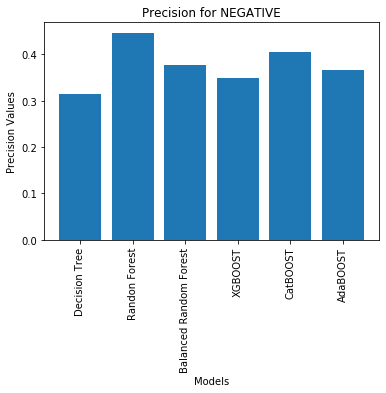

In [158]:
plt.bar(range(len(precision_no_model)), list(precision_no_model.values()), align='center')
plt.xticks(range(len(precision_no_model)), list(precision_no_model.keys()), rotation=90)
plt.title('Precision for NEGATIVE')
plt.xlabel('Models')
plt.ylabel('Precision Values')

#### Precision YES 

In [138]:
precision_yes_model = {"Decision Tree":0.769,
                      "Randon Forest":0.793,
                      "Balanced Random Forest":0.82,
                      "XGBOOST":0.81,
                      "CatBOOST":0.804,
                      "AdaBOOST":0.805
                     }
precision_yes_model

{'Decision Tree': 0.769,
 'Randon Forest': 0.793,
 'Balanced Random Forest': 0.82,
 'XGBOOST': 0.81,
 'CatBOOST': 0.804,
 'AdaBOOST': 0.805}

Text(0, 0.5, 'Precision Values')

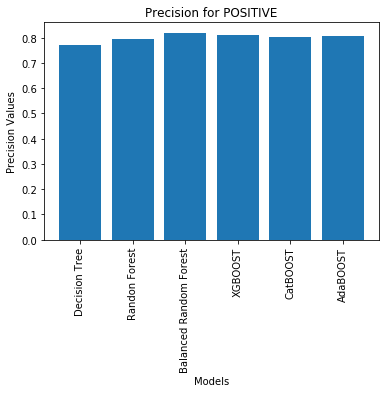

In [159]:
plt.bar(range(len(precision_yes_model)), list(precision_yes_model.values()), align='center')
plt.xticks(range(len(precision_yes_model)), list(precision_yes_model.keys()), rotation=90)
plt.title('Precision for POSITIVE')
plt.xlabel('Models')
plt.ylabel('Precision Values')

#### TOTAL Precision

In [140]:
precision_model = {"Decision Tree":0.653,
                   "Randon Forest":0.705,
                   "Balanced Random Forest":0.706,
                   "XGBOOST":0.692,
                   "CatBOOST":0.703,
                   "AdaBOOST":0.693
                  }
precision_model

{'Decision Tree': 0.653,
 'Randon Forest': 0.705,
 'Balanced Random Forest': 0.706,
 'XGBOOST': 0.692,
 'CatBOOST': 0.703,
 'AdaBOOST': 0.693}

Text(0, 0.5, 'Precision Values')

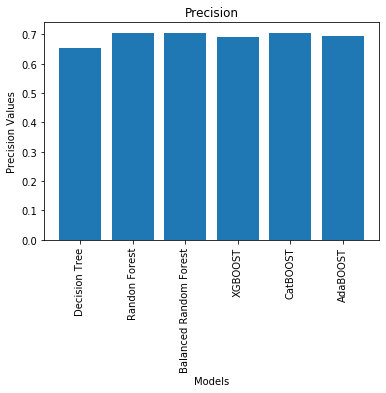

In [141]:
plt.bar(range(len(precision_model)), list(precision_model.values()), align='center')
plt.xticks(range(len(precision_model)), list(precision_model.keys()), rotation=90)
plt.title('Precision')
plt.xlabel('Models')
plt.ylabel('Precision Values')

## Recall

#### Recall NO 

In [142]:
recall_no_model = {"Decision Tree":0.496,
                   "Randon Forest":0.423,
                   "Balanced Random Forest":0.625,
                   "XGBOOST":0.649,
                   "CatBOOST":0.535,
                   "AdaBOOST":0.572
                  }
recall_no_model

{'Decision Tree': 0.496,
 'Randon Forest': 0.423,
 'Balanced Random Forest': 0.625,
 'XGBOOST': 0.649,
 'CatBOOST': 0.535,
 'AdaBOOST': 0.572}

Text(0, 0.5, 'Recall Values')

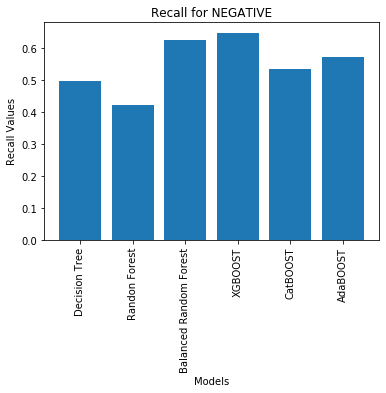

In [160]:
plt.bar(range(len(recall_no_model)), list(recall_no_model.values()), align='center')
plt.xticks(range(len(recall_no_model)), list(recall_no_model.keys()), rotation=90)
plt.title('Recall for NEGATIVE')
plt.xlabel('Models')
plt.ylabel('Recall Values')

#### Recall YES 

In [144]:
recall_yes_model = {"Decision Tree":0.61,
                   "Randon Forest":0.806,
                   "Balanced Random Forest":0.624,
                   "XGBOOST":0.551,
                   "CatBOOST":0.713,
                   "AdaBOOST":0.635
                  }
recall_yes_model

{'Decision Tree': 0.61,
 'Randon Forest': 0.806,
 'Balanced Random Forest': 0.624,
 'XGBOOST': 0.551,
 'CatBOOST': 0.713,
 'AdaBOOST': 0.635}

Text(0, 0.5, 'Recall Values')

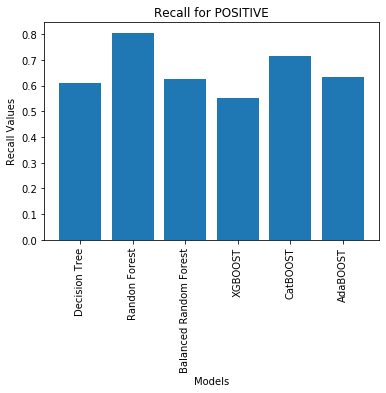

In [161]:
plt.bar(range(len(recall_yes_model)), list(recall_yes_model.values()), align='center')
plt.xticks(range(len(recall_yes_model)), list(recall_yes_model.keys()), rotation=90)
plt.title('Recall for POSITIVE')
plt.xlabel('Models')
plt.ylabel('Recall Values')

#### TOTAL Recall 

In [146]:
recall_model = {"Decision Tree":0.580,
                   "Randon Forest":0.705,
                   "Balanced Random Forest":0.623,
                   "XGBOOST":0.571,
                   "CatBOOST":0.661,
                   "AdaBOOST":0.621
                  }
recall_model

{'Decision Tree': 0.58,
 'Randon Forest': 0.705,
 'Balanced Random Forest': 0.623,
 'XGBOOST': 0.571,
 'CatBOOST': 0.661,
 'AdaBOOST': 0.621}

Text(0, 0.5, 'Recall Values')

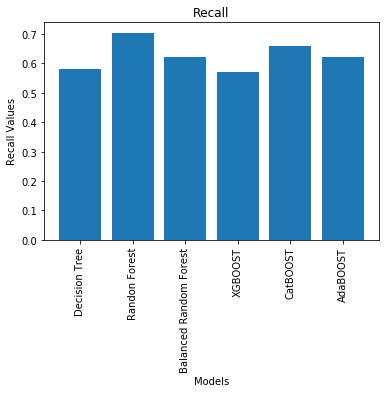

In [147]:
plt.bar(range(len(recall_model)), list(recall_model.values()), align='center')
plt.xticks(range(len(recall_model)), list(recall_model.keys()), rotation=90)
plt.title('Recall')
plt.xlabel('Models')
plt.ylabel('Recall Values')

## F1 Score

#### F1 Score NO 

In [148]:
f1_no_model = {"Decision Tree":0.382,
                   "Randon Forest":0.427,
                   "Balanced Random Forest":0.465,
                   "XGBOOST":0.44,
                   "CatBOOST":0.454,
                   "AdaBOOST":0.443
                  }
f1_no_model

{'Decision Tree': 0.382,
 'Randon Forest': 0.427,
 'Balanced Random Forest': 0.465,
 'XGBOOST': 0.44,
 'CatBOOST': 0.454,
 'AdaBOOST': 0.443}

Text(0, 0.5, 'F1 Score Values')

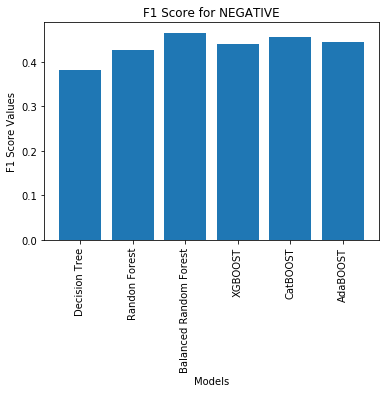

In [162]:
plt.bar(range(len(f1_no_model)), list(f1_no_model.values()), align='center')
plt.xticks(range(len(f1_no_model)), list(f1_no_model.keys()), rotation=90)
plt.title('F1 Score for NEGATIVE')
plt.xlabel('Models')
plt.ylabel('F1 Score Values')

#### F1 Score YES

In [150]:
f1_yes_model = {"Decision Tree":0.677,
                   "Randon Forest":0.796,
                   "Balanced Random Forest":0.704,
                   "XGBOOST":0.65,
                   "CatBOOST":0.752,
                   "AdaBOOST":0.709
                  }
f1_yes_model

{'Decision Tree': 0.677,
 'Randon Forest': 0.796,
 'Balanced Random Forest': 0.704,
 'XGBOOST': 0.65,
 'CatBOOST': 0.752,
 'AdaBOOST': 0.709}

Text(0, 0.5, 'F1 Score Values')

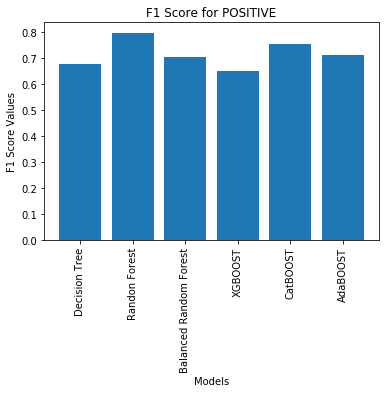

In [163]:
plt.bar(range(len(f1_yes_model)), list(f1_yes_model.values()), align='center')
plt.xticks(range(len(f1_yes_model)), list(f1_yes_model.keys()), rotation=90)
plt.title('F1 Score for POSITIVE')
plt.xlabel('Models')
plt.ylabel('F1 Score Values')

#### TOTAL F1 Score 

In [152]:
f1_model = {"Decision Tree":0.603,
                   "Randon Forest":0.702,
                   "Balanced Random Forest":0.644,
                   "XGBOOST":0.594,
                   "CatBOOST":0.674,
                   "AdaBOOST":0.641
                  }
f1_model

{'Decision Tree': 0.603,
 'Randon Forest': 0.702,
 'Balanced Random Forest': 0.644,
 'XGBOOST': 0.594,
 'CatBOOST': 0.674,
 'AdaBOOST': 0.641}

Text(0, 0.5, 'F1 Score Values')

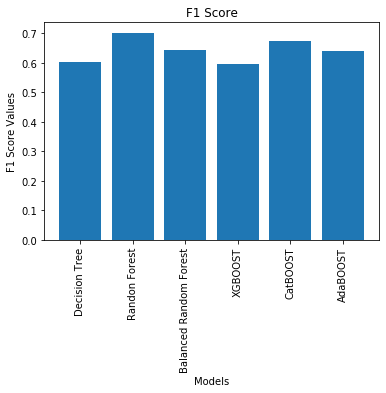

In [153]:
plt.bar(range(len(f1_model)), list(f1_model.values()), align='center')
plt.xticks(range(len(f1_model)), list(f1_model.keys()), rotation=90)
plt.title('F1 Score')
plt.xlabel('Models')
plt.ylabel('F1 Score Values')

## Accuracy

In [154]:
acc_model = {"Decision Tree":0.580,
                   "Randon Forest":0.705,
                   "Balanced Random Forest":0.623,
                   "XGBOOST":0.571,
                   "CatBOOST":0.661,
                   "AdaBOOST":0.621
                  }
acc_model

{'Decision Tree': 0.58,
 'Randon Forest': 0.705,
 'Balanced Random Forest': 0.623,
 'XGBOOST': 0.571,
 'CatBOOST': 0.661,
 'AdaBOOST': 0.621}

Text(0, 0.5, 'Accuracy Values')

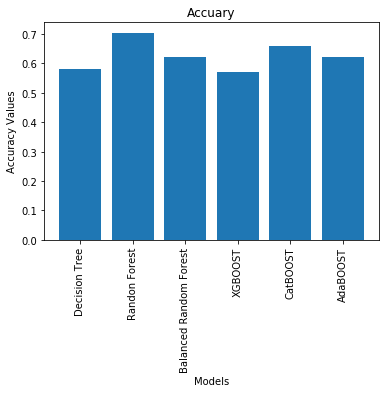

In [155]:
plt.bar(range(len(acc_model)), list(acc_model.values()), align='center')
plt.xticks(range(len(acc_model)), list(acc_model.keys()), rotation=90)
plt.title('Accuary')
plt.xlabel('Models')
plt.ylabel('Accuracy Values')

## AUC

In [156]:
auc_model = {"Decision Tree":0.571,
                   "Randon Forest":0.642,
                   "Balanced Random Forest":0.665,
                   "XGBOOST":0.661,
                   "CatBOOST":0.667,
                   "AdaBOOST":0.647
                  }
auc_model

{'Decision Tree': 0.571,
 'Randon Forest': 0.642,
 'Balanced Random Forest': 0.665,
 'XGBOOST': 0.661,
 'CatBOOST': 0.667,
 'AdaBOOST': 0.647}

Text(0, 0.5, 'ROC AUC Values')

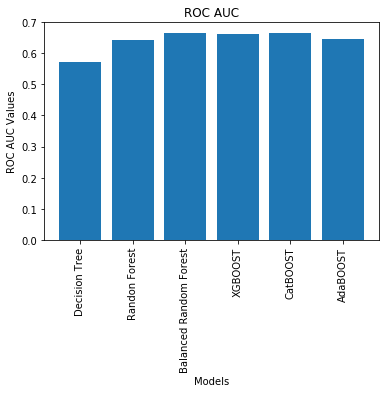

In [157]:
plt.bar(range(len(auc_model)), list(auc_model.values()), align='center')
plt.xticks(range(len(auc_model)), list(auc_model.keys()), rotation=90)
plt.title('ROC AUC')
plt.xlabel('Models')
plt.ylabel('ROC AUC Values')

# FEATURES IMPORTANCE

#### TO CATBOOST BY SELECTED PARAMETERS WITHOUT PCA

In [71]:
clf_for_feat_importance = catboost.CatBoostClassifier(scale_pos_weight=0.3,depth=7,iterations=250,learning_rate=0.01,l2_leaf_reg=5)
clf_for_feat_importance.fit(x,y.replace({"yes":1.0, "no":0.0}))

0:	learn: 0.6902646	total: 116ms	remaining: 28.9s
1:	learn: 0.6885663	total: 253ms	remaining: 31.3s
2:	learn: 0.6863562	total: 392ms	remaining: 32.3s
3:	learn: 0.6842493	total: 530ms	remaining: 32.6s
4:	learn: 0.6815932	total: 672ms	remaining: 32.9s
5:	learn: 0.6797615	total: 811ms	remaining: 33s
6:	learn: 0.6776023	total: 959ms	remaining: 33.3s
7:	learn: 0.6755897	total: 1.12s	remaining: 33.9s
8:	learn: 0.6735559	total: 1.28s	remaining: 34.3s
9:	learn: 0.6712805	total: 1.43s	remaining: 34.3s
10:	learn: 0.6694544	total: 1.57s	remaining: 34.2s
11:	learn: 0.6674929	total: 1.71s	remaining: 34s
12:	learn: 0.6662428	total: 1.86s	remaining: 33.9s
13:	learn: 0.6648400	total: 2s	remaining: 33.7s
14:	learn: 0.6636414	total: 2.14s	remaining: 33.6s
15:	learn: 0.6611446	total: 2.28s	remaining: 33.4s
16:	learn: 0.6588638	total: 2.46s	remaining: 33.8s
17:	learn: 0.6568786	total: 2.59s	remaining: 33.4s
18:	learn: 0.6543375	total: 2.74s	remaining: 33.3s
19:	learn: 0.6519974	total: 2.88s	remaining: 33.

161:	learn: 0.4624793	total: 23.1s	remaining: 12.6s
162:	learn: 0.4613573	total: 23.2s	remaining: 12.4s
163:	learn: 0.4599240	total: 23.4s	remaining: 12.3s
164:	learn: 0.4586697	total: 23.5s	remaining: 12.1s
165:	learn: 0.4577076	total: 23.7s	remaining: 12s
166:	learn: 0.4565026	total: 23.9s	remaining: 11.9s
167:	learn: 0.4557585	total: 24s	remaining: 11.7s
168:	learn: 0.4550502	total: 24.1s	remaining: 11.6s
169:	learn: 0.4539363	total: 24.3s	remaining: 11.4s
170:	learn: 0.4525237	total: 24.5s	remaining: 11.3s
171:	learn: 0.4511909	total: 24.6s	remaining: 11.2s
172:	learn: 0.4500232	total: 24.8s	remaining: 11s
173:	learn: 0.4491673	total: 24.9s	remaining: 10.9s
174:	learn: 0.4479259	total: 25.1s	remaining: 10.7s
175:	learn: 0.4473032	total: 25.2s	remaining: 10.6s
176:	learn: 0.4462169	total: 25.4s	remaining: 10.5s
177:	learn: 0.4454017	total: 25.5s	remaining: 10.3s
178:	learn: 0.4442638	total: 25.7s	remaining: 10.2s
179:	learn: 0.4433948	total: 25.8s	remaining: 10s
180:	learn: 0.442015

In [73]:
feat_importance = list(zip(x.columns, clf_for_feat_importance.get_feature_importance()))
feat_importance = sorted(feat_importance, key=lambda tup: tup[1], reverse=True)
feat_importance

[('count_ETCO2', 2.9162626993263703),
 ('count_VTsetting', 2.8774239731058877),
 ('min_ArtBPD', 1.6571624541027379),
 ('median_Na-ABG', 1.6221531639800055),
 ('count_FiO2', 1.461998580510823),
 ('std_PEEP', 1.3279995710187624),
 ('max_Temp', 1.2209820265585565),
 ('median_Albumin', 1.1575402624491085),
 ('count_SaturationPulse', 1.128790595430638),
 ('count_ArtBPM', 1.1179607454071847),
 ('count_CCPOT', 1.1159479557603853),
 ('min_max_ETCO2', 1.1065403323609209),
 ('max_WCC', 1.0449230457807244),
 ('min_max_SuctionsPerDay', 1.0387701254251924),
 ('count_TotalMinuteVolume', 1.029895967025318),
 ('median_GlucoseABG', 1.0231252735663565),
 ('std_WCC', 1.009704197263861),
 ('std_Albumin', 0.9492399089617046),
 ('median_PT-INR', 0.9460104141076944),
 ('count_ArtBPS', 0.9439564516828028),
 ('count_HR', 0.9231146055031372),
 ('min_max_Na-ABG', 0.9171837141272022),
 ('median_PaCO2', 0.8986102583515738),
 ('std_ETCO2', 0.8954739901748411),
 ('min_max_WCC', 0.8823541921026905),
 ('min_ETCO2', 0.

# LEARNING CURVE

#### TO CATBOOST BY SELECTED PARAMETERS WITH PCA

In [167]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring="f1")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\envs\\dandush\\lib\\site-packages\\matplotlib\\pyplot.py'>

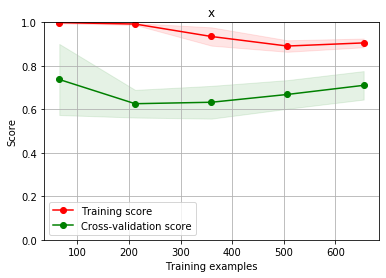

In [168]:
plot_learning_curve(catboost.CatBoostClassifier(scale_pos_weight=0.3, learning_rate=0.001, l2_leaf_reg=5,
                                       iterations=250, depth=7), "x", x, y_bool, (0, 1), cv=10, n_jobs=10)